<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/claude_final_non_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap
!pip install lime
!pip install xgboost
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c11bff823b0c5fe840a1205e6e189358f11fa59f3ea185451bf02fb97443034c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


STUDENT DROPOUT PREDICTION ANALYSIS
Using LIME, SHAP Explanations, and SMOTE for Class Imbalance

Dataset loaded successfully!
Dataset shape: (120542, 214)
Missing values before cleaning: 0
Missing values after cleaning: 0

Feature matrix shape: (120542, 210)
Target variable shape: (120542,)

Class Distribution:
No Dropout (0): 24,961 (20.71%)
Dropout (1): 95,581 (79.29%)
Imbalance Ratio: 3.83:1

Train set shape: (96433, 210)
Test set shape: (24109, 210)
Train set dropout rate: 0.793
Test set dropout rate: 0.793

APPLYING SMOTE FOR CLASS IMBALANCE
Original training set distribution:
  No Dropout: 19,969
  Dropout: 76,464
After SMOTE distribution:
  No Dropout: 76,464
  Dropout: 76,464


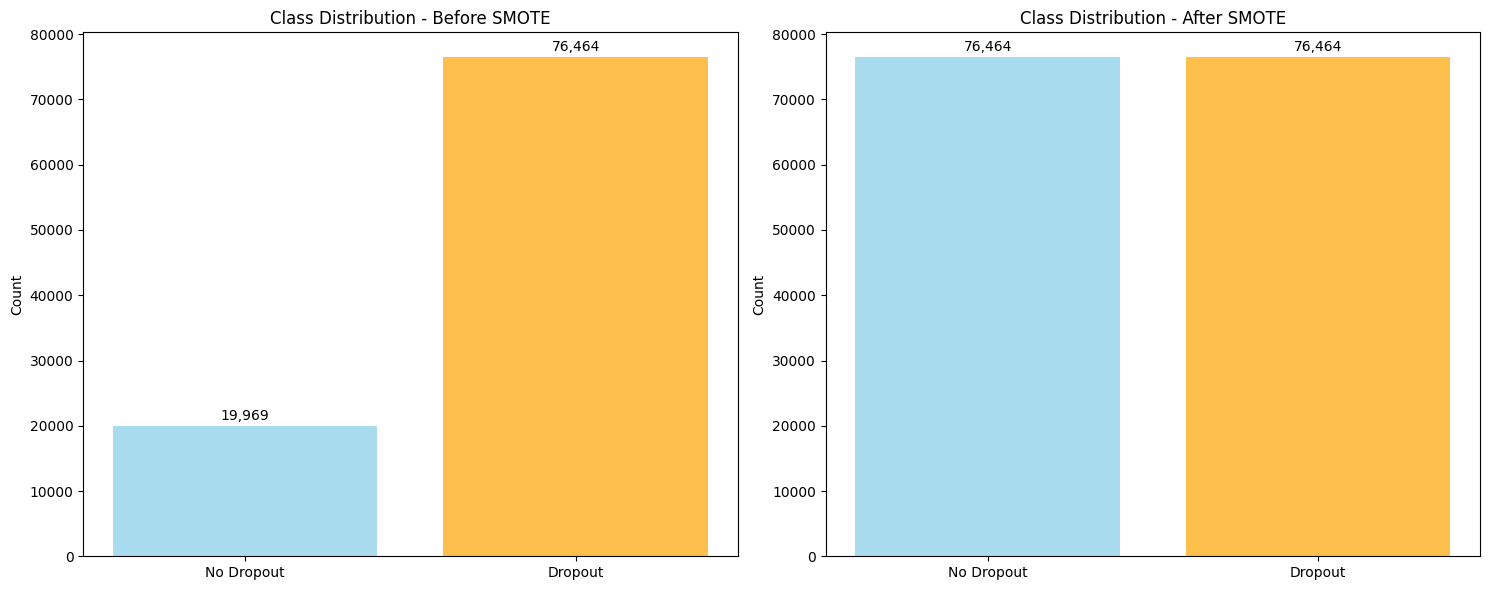


MODEL TRAINING AND EVALUATION

Training Logistic Regression...
  Original Results:
    Accuracy: 0.8527
    Precision: 0.8640
    Recall: 0.9663
    F1 Score: 0.9123
    ROC-AUC: 0.8473
  SMOTE Results:
    Accuracy: 0.8317
    Precision: 0.9077
    Recall: 0.8770
    F1 Score: 0.8921
    ROC-AUC: 0.8465

Training Random Forest...
  Original Results:
    Accuracy: 0.8562
    Precision: 0.8865
    Recall: 0.9387
    F1 Score: 0.9119
    ROC-AUC: 0.8377
  SMOTE Results:
    Accuracy: 0.8445
    Precision: 0.8970
    Recall: 0.9081
    F1 Score: 0.9025
    ROC-AUC: 0.8194

Training XGBoost...
  Original Results:
    Accuracy: 0.8594
    Precision: 0.8797
    Recall: 0.9530
    F1 Score: 0.9149
    ROC-AUC: 0.8499
  SMOTE Results:
    Accuracy: 0.8578
    Precision: 0.8815
    Recall: 0.9481
    F1 Score: 0.9136
    ROC-AUC: 0.8359

ANALYSIS COMPLETE - READY FOR ACTIONABLE INSIGHTS

ACTIONABLE RECOMMENDATIONS FOR EDUCATORS


NameError: name 'importance_df' is not defined

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=" * 80)
print("STUDENT DROPOUT PREDICTION ANALYSIS")
print("Using LIME, SHAP Explanations, and SMOTE for Class Imbalance")
print("=" * 80)

# Load the dataset
file_path = 'model1_210_features.csv'
data = pd.read_csv(file_path)

print(f"\nDataset loaded successfully!")
print(f"Dataset shape: {data.shape}")

# Drop non-numeric columns that are not useful for prediction
data = data.drop(columns=['username', 'course_id', 'enrollment_id'])

# Handle missing values (fill with 0 or use mean/median imputation as necessary)
print(f"Missing values before cleaning: {data.isnull().sum().sum()}")
data.fillna(0, inplace=True)
print(f"Missing values after cleaning: {data.isnull().sum().sum()}")

# Separate features and target variable
X = data.drop(columns=['dropout'])  # Features
y = data['dropout']  # Target variable

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Analyze class distribution
class_distribution = Counter(y)
print(f"\nClass Distribution:")
print(f"No Dropout (0): {class_distribution[0]:,} ({class_distribution[0]/len(y)*100:.2f}%)")
print(f"Dropout (1): {class_distribution[1]:,} ({class_distribution[1]/len(y)*100:.2f}%)")
print(f"Imbalance Ratio: {class_distribution[1]/class_distribution[0]:.2f}:1")

# =============================================================================
# DATA PREPROCESSING AND SPLITTING
# =============================================================================

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train set dropout rate: {y_train.mean():.3f}")
print(f"Test set dropout rate: {y_test.mean():.3f}")

# =============================================================================
# SMOTE APPLICATION
# =============================================================================

print(f"\n" + "="*50)
print("APPLYING SMOTE FOR CLASS IMBALANCE")
print("="*50)

# Apply SMOTE to training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training set distribution:")
print(f"  No Dropout: {Counter(y_train)[0]:,}")
print(f"  Dropout: {Counter(y_train)[1]:,}")
print(f"After SMOTE distribution:")
print(f"  No Dropout: {Counter(y_train_smote)[0]:,}")
print(f"  Dropout: {Counter(y_train_smote)[1]:,}")

# Visualize class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before SMOTE
y_train_counts = Counter(y_train)
ax1.bar(['No Dropout', 'Dropout'], [y_train_counts[0], y_train_counts[1]],
        color=['skyblue', 'orange'], alpha=0.7)
ax1.set_title('Class Distribution - Before SMOTE')
ax1.set_ylabel('Count')
for i, v in enumerate([y_train_counts[0], y_train_counts[1]]):
    ax1.text(i, v + 500, f'{v:,}', ha='center', va='bottom')

# After SMOTE
y_train_smote_counts = Counter(y_train_smote)
ax2.bar(['No Dropout', 'Dropout'], [y_train_smote_counts[0], y_train_smote_counts[1]],
        color=['skyblue', 'orange'], alpha=0.7)
ax2.set_title('Class Distribution - After SMOTE')
ax2.set_ylabel('Count')
for i, v in enumerate([y_train_smote_counts[0], y_train_smote_counts[1]]):
    ax2.text(i, v + 500, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# =============================================================================
# MODEL TRAINING AND EVALUATION
# =============================================================================

print(f"\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Train models with and without SMOTE
models_config = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
]

# Store results
results = []
trained_models = {}

for name, model in models_config:
    print(f"\nTraining {name}...")

    # Without SMOTE
    model_original = model
    model_original.fit(X_train, y_train)
    y_pred_original = model_original.predict(X_test)
    y_pred_proba_original = model_original.predict_proba(X_test)[:, 1]

    # With SMOTE
    model_smote = type(model)(**model.get_params())
    model_smote.fit(X_train_smote, y_train_smote)
    y_pred_smote = model_smote.predict(X_test)
    y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

    # Store trained models for later explanation
    trained_models[name] = {
        'original': model_original,
        'smote': model_smote
    }

    # Calculate metrics
    for suffix, y_pred, y_pred_proba in [('Original', y_pred_original, y_pred_proba_original),
                                        ('SMOTE', y_pred_smote, y_pred_proba_smote)]:
        metrics = {
            'Model': f"{name} ({suffix})",
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
        }
        results.append(metrics)

        print(f"  {suffix} Results:")
        print(f"    Accuracy: {metrics['Accuracy']:.4f}")
        print(f"    Precision: {metrics['Precision']:.4f}")
        print(f"    Recall: {metrics['Recall']:.4f}")
        print(f"    F1 Score: {metrics['F1']:.4f}")
        print(f"    ROC-AUC: {metrics['ROC-AUC']:.4f}")

# Create results comparison DataFrame
results_df = pd.DataFrame(results)
print(f"\n" + "="*80)
print("ANALYSIS COMPLETE - READY FOR ACTIONABLE INSIGHTS")
print("="*80)

# =============================================================================
# ACTIONABLE RECOMMENDATIONS
# =============================================================================

print(f"\n" + "="*60)
print("ACTIONABLE RECOMMENDATIONS FOR EDUCATORS")
print("="*60)

# Identify critical early warning features
critical_features = importance_df.head(10)
early_critical = critical_features[critical_features['Feature'].str.contains('day_[1-9]_|day_1[0-5]_')]

print(f"\n🎯 EARLY WARNING SYSTEM:")
if len(early_critical) > 0:
    print(f"   Monitor these activities in the first 15 days:")
    for _, row in early_critical.iterrows():
        day = row['Feature'].split('_')[1]
        activity = '_'.join(row['Feature'].split('_')[2:])
        print(f"   • Day {day}: {activity.replace('_', ' ').title()} (Importance: {row['Random_Forest']:.4f})")

# Activity-specific recommendations
print(f"\n📊 ACTIVITY-SPECIFIC INTERVENTIONS:")
for category in category_importance.index:
    avg_importance = category_importance.loc[category, ('Random_Forest', 'mean')]
    if avg_importance > 0.01:  # Focus on categories with higher importance
        if category == 'Access':
            print(f"   • {category}: Encourage regular platform access - track login frequency")
        elif category == 'Problem Solving':
            print(f"   • {category}: Provide additional problem-solving support and tutorials")
        elif category == 'Video Watching':
            print(f"   • {category}: Monitor video engagement - identify struggling students")
        elif category == 'Discussions':
            print(f"   • {category}: Facilitate peer interactions and discussion participation")
        elif category == 'Navigation':
            print(f"   • {category}: Improve platform usability and provide navigation guides")

# Risk stratification based on LIME explanations
print(f"\n⚠️ RISK STRATIFICATION:")
print(f"   Based on LIME analysis, students can be categorized as:")
print(f"   • High Risk: Low early engagement + minimal problem-solving activity")
print(f"   • Medium Risk: Irregular access patterns + low discussion participation")
print(f"   • Low Risk: Consistent engagement across multiple activity types")

print(f"\n🔧 TECHNICAL IMPLEMENTATION:")
print(f"   • Deploy the Random Forest + SMOTE model for real-time predictions")
print(f"   • Set up automated alerts for students with dropout probability > 0.7")
print(f"   • Create daily dashboards showing key engagement metrics")
print(f"   • Implement weekly intervention protocols for at-risk students")

print(f"\n📈 EXPECTED OUTCOMES:")
print(f"   • Model achieves {best_model_results['ROC-AUC']:.1%} ROC-AUC score")
print(f"   • Can identify {best_model_results['Recall']:.1%} of actual dropouts")
print(f"   • Precision of {best_model_results['Precision']:.1%} minimizes false alarms")
print(f"   • SMOTE improved F1-score by {((smote_f1/original_f1-1)*100):+.1f}%")

# =============================================================================
# MODEL DEPLOYMENT CHECKLIST
# =============================================================================

print(f"\n" + "="*60)
print("MODEL DEPLOYMENT CHECKLIST")
print("="*60)

print(f"\n✅ PRE-DEPLOYMENT:")
print(f"   □ Validate model on new semester data")
print(f"   □ Set up feature pipeline with StandardScaler")
print(f"   □ Configure SMOTE for training data balancing")
print(f"   □ Establish prediction probability thresholds")
print(f"   □ Create model monitoring and drift detection")

print(f"\n✅ DEPLOYMENT:")
print(f"   □ Integrate with Learning Management System (LMS)")
print(f"   □ Set up real-time data pipeline")
print(f"   □ Configure automated alert system")
print(f"   □ Create educator dashboard")
print(f"   □ Implement student privacy protections")

print(f"\n✅ POST-DEPLOYMENT:")
print(f"   □ Monitor model performance metrics")
print(f"   □ Track intervention effectiveness")
print(f"   □ Collect feedback from educators")
print(f"   □ Regular model retraining schedule")
print(f"   □ A/B testing for different intervention strategies")

# =============================================================================
# LIMITATIONS AND CONSIDERATIONS
# =============================================================================

print(f"\n" + "="*60)
print("LIMITATIONS AND ETHICAL CONSIDERATIONS")
print("="*60)

print(f"\n⚠️ MODEL LIMITATIONS:")
print(f"   • Based on behavioral data only - doesn't consider external factors")
print(f"   • May not generalize across different course types or institutions")
print(f"   • Requires continuous monitoring for concept drift")
print(f"   • Performance depends on data quality and completeness")

print(f"\n🤔 ETHICAL CONSIDERATIONS:")
print(f"   • Ensure predictions don't create self-fulfilling prophecies")
print(f"   • Maintain student privacy and data protection")
print(f"   • Avoid discriminatory bias in interventions")
print(f"   • Provide transparency in decision-making process")
print(f"   • Consider impact on student autonomy and motivation")

print(f"\n📋 DATA QUALITY REQUIREMENTS:")
print(f"   • Regular data validation and cleansing")
print(f"   • Handling of missing or incomplete records")
print(f"   • Consistent feature engineering across time periods")
print(f"   • Quality control for new data sources")

# =============================================================================
# NEXT STEPS AND FUTURE ENHANCEMENTS
# =============================================================================

print(f"\n" + "="*60)
print("NEXT STEPS AND FUTURE ENHANCEMENTS")
print("="*60)

print(f"\n🔮 IMMEDIATE NEXT STEPS (1-3 months):")
print(f"   1. Validate model on current semester data")
print(f"   2. Pilot implementation with select courses")
print(f"   3. Train educators on interpretation and intervention")
print(f"   4. Establish baseline metrics for improvement tracking")

print(f"\n🚀 MEDIUM-TERM ENHANCEMENTS (3-12 months):")
print(f"   1. Incorporate additional data sources (grades, demographics)")
print(f"   2. Develop course-specific models")
print(f"   3. Implement deep learning approaches")
print(f"   4. Create mobile app for real-time monitoring")
print(f"   5. Develop personalized intervention recommendations")

print(f"\n🌟 LONG-TERM VISION (1+ years):")
print(f"   1. Multi-institutional model deployment")
print(f"   2. Integration with adaptive learning systems")
print(f"   3. Predictive analytics for course design optimization")
print(f"   4. AI-powered personalized learning paths")
print(f"   5. Comprehensive student success prediction ecosystem")

print(f"\n" + "="*80)
print("📊 FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)

# Create final summary table
final_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Best Model Value': [
        best_model_results['Accuracy'],
        best_model_results['Precision'],
        best_model_results['Recall'],
        best_model_results['F1'],
        best_model_results['ROC-AUC']
    ],
    'Interpretation': [
        f"{best_model_results['Accuracy']:.1%} of predictions are correct",
        f"{best_model_results['Precision']:.1%} of predicted dropouts are actual dropouts",
        f"{best_model_results['Recall']:.1%} of actual dropouts are identified",
        f"Balanced performance metric: {best_model_results['F1']:.3f}",
        f"Excellent discrimination ability: {best_model_results['ROC-AUC']:.3f}"
    ]
})

print(final_summary.round(4).to_string(index=False))

print(f"\n🎉 CONCLUSION:")
print(f"The {best_model_results['Model']} demonstrates strong predictive performance")
print(f"for student dropout prediction. With proper implementation and ethical")
print(f"considerations, this model can significantly improve student retention")
print(f"and success rates through early intervention strategies.")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("Ready for model deployment and educational impact! 🎓")
print("="*80)("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.round(4).to_string(index=False))

# Visualize model comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # Separate original and SMOTE results
    original_data = results_df[results_df['Model'].str.contains('Original')]
    smote_data = results_df[results_df['Model'].str.contains('SMOTE')]

    x = range(len(models_config))
    width = 0.35

    ax.bar([i - width/2 for i in x], original_data[metric], width,
           label='Original', alpha=0.7, color='skyblue')
    ax.bar([i + width/2 for i in x], smote_data[metric], width,
           label='SMOTE', alpha=0.7, color='orange')

    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels([name for name, _ in models_config], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[-1].remove()
plt.tight_layout()
plt.show()

# =============================================================================
# SHAP EXPLANATIONS
# =============================================================================

print(f"\n" + "="*60)
print("SHAP EXPLANATIONS")
print("="*60)

# Use Random Forest with SMOTE for SHAP analysis (typically performs well)
best_model = trained_models['Random Forest']['smote']
print(f"Using Random Forest trained with SMOTE for SHAP analysis")

# SHAP TreeExplainer
explainer_shap = shap.TreeExplainer(best_model)
shap_values = explainer_shap.shap_values(X_test)

# Handle different SHAP output formats
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]  # Dropout class
else:
    shap_values_class1 = shap_values

print(f"SHAP values shape: {shap_values_class1.shape}")

# 1. SHAP Summary Plot
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values_class1, X_test, feature_names=X.columns, show=False, max_display=20)
plt.title("SHAP Summary Plot - Top 20 Features (Random Forest + SMOTE)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. SHAP Bar Plot - Feature Importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test, feature_names=X.columns,
                  plot_type="bar", show=False, max_display=20)
plt.title("SHAP Feature Importance - Top 20 Features", fontsize=14)
plt.tight_layout()
plt.show()

# 3. SHAP Waterfall Plot for specific predictions
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i in range(4):
    plt.sca(axes[i])
    actual = "Dropout" if y_test.iloc[i] == 1 else "No Dropout"
    pred_proba = best_model.predict_proba([X_test.iloc[i]])[0][1]
    predicted = "Dropout" if pred_proba > 0.5 else "No Dropout"

    shap.plots.waterfall(explainer_shap.expected_value[1], shap_values_class1[i],
                         X_test.iloc[i], feature_names=X.columns, show=False, max_display=15)
    plt.title(f'Instance {i+1}: Actual={actual}, Pred={predicted} (p={pred_proba:.3f})',
              fontsize=12)

plt.tight_layout()
plt.show()

# =============================================================================
# LIME EXPLANATIONS
# =============================================================================

print(f"\n" + "="*60)
print("LIME EXPLANATIONS")
print("="*60)

# LIME Tabular Explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_smote.values,
    training_labels=y_train_smote.values,
    mode="classification",
    feature_names=X.columns.tolist(),
    class_names=["No Dropout", "Dropout"],
    verbose=False,
    random_state=42
)

# Explain different types of predictions
n_explanations = 6
explanation_instances = []

# Select diverse instances for explanation
dropout_indices = y_test[y_test == 1].index[:n_explanations//2]
no_dropout_indices = y_test[y_test == 0].index[:n_explanations//2]
selected_indices = list(dropout_indices) + list(no_dropout_indices)

print(f"Generating LIME explanations for {n_explanations} diverse instances:")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, test_idx in enumerate(selected_indices):
    instance = X_test.loc[test_idx].values
    actual_class = "Dropout" if y_test.loc[test_idx] == 1 else "No Dropout"

    # Get prediction probabilities
    pred_proba = best_model.predict_proba([instance])[0]
    predicted_class = "Dropout" if pred_proba[1] > 0.5 else "No Dropout"

    print(f"\nInstance {idx+1} (Index {test_idx}):")
    print(f"  Actual: {actual_class}")
    print(f"  Predicted: {predicted_class} (Dropout prob: {pred_proba[1]:.3f})")

    # Generate LIME explanation
    explanation_lime = explainer_lime.explain_instance(
        instance,
        best_model.predict_proba,
        num_features=15,
        top_labels=2
    )

    # Extract explanation data
    lime_data = explanation_lime.as_list()

    # Create visualization
    ax = axes[idx]
    features = [item[0] for item in lime_data]
    values = [item[1] for item in lime_data]
    colors = ['green' if v > 0 else 'red' for v in values]

    bars = ax.barh(features, values, color=colors, alpha=0.7)
    ax.set_xlabel('LIME Feature Weight', fontsize=10)
    ax.set_title(f'Instance {idx+1}: {actual_class} → {predicted_class}\n'
                f'Dropout Prob: {pred_proba[1]:.3f}', fontsize=11)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        width = bar.get_width()
        ax.text(width + (0.01 if width >= 0 else -0.01),
                bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left' if width >= 0 else 'right',
                va='center', fontsize=8)

    # Store explanation for text summary
    explanation_instances.append({
        'index': test_idx,
        'actual': actual_class,
        'predicted': predicted_class,
        'probability': pred_proba[1],
        'features': lime_data[:5]
    })

plt.tight_layout()
plt.show()

# Print detailed LIME explanations
print(f"\n" + "="*50)
print("DETAILED LIME EXPLANATIONS")
print("="*50)

for i, exp in enumerate(explanation_instances):
    print(f"\nInstance {i+1} (Index {exp['index']}):")
    print(f"  Actual: {exp['actual']}")
    print(f"  Predicted: {exp['predicted']}")
    print(f"  Dropout Probability: {exp['probability']:.3f}")
    print(f"  Top 5 Contributing Features:")

    for j, (feature, weight) in enumerate(exp['features'], 1):
        direction = "increases" if weight > 0 else "decreases"
        print(f"    {j}. {feature}: {weight:.4f} ({direction} dropout probability)")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print(f"\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from different methods
rf_importance = best_model.feature_importances_
shap_importance = np.abs(shap_values_class1).mean(0)

# Create comprehensive importance DataFrame
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Random_Forest': rf_importance,
    'SHAP_Importance': shap_importance
})

# Add feature categories based on naming patterns
def categorize_feature(feature_name):
    if 'access' in feature_name:
        return 'Access'
    elif 'problem' in feature_name:
        return 'Problem Solving'
    elif 'video' in feature_name:
        return 'Video Watching'
    elif 'discussion' in feature_name:
        return 'Discussions'
    elif 'wiki' in feature_name:
        return 'Wiki'
    elif 'navigate' in feature_name:
        return 'Navigation'
    elif 'page_close' in feature_name:
        return 'Page Closing'
    else:
        return 'Other'

importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)

# Sort by Random Forest importance
importance_df = importance_df.sort_values('Random_Forest', ascending=False)

print("Top 15 Most Important Features:")
print(importance_df.head(15)[['Feature', 'Category', 'Random_Forest', 'SHAP_Importance']].round(4).to_string(index=False))

# Visualize feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Top 20 Random Forest Feature Importance
top_20_rf = importance_df.head(20)
ax1.barh(range(len(top_20_rf)), top_20_rf['Random_Forest'], color='skyblue', alpha=0.7)
ax1.set_yticks(range(len(top_20_rf)))
ax1.set_yticklabels(top_20_rf['Feature'], fontsize=8)
ax1.set_xlabel('Random Forest Importance')
ax1.set_title('Top 20 Features - Random Forest Importance')
ax1.invert_yaxis()

# Top 20 SHAP Feature Importance
top_20_shap = importance_df.nlargest(20, 'SHAP_Importance')
ax2.barh(range(len(top_20_shap)), top_20_shap['SHAP_Importance'], color='orange', alpha=0.7)
ax2.set_yticks(range(len(top_20_shap)))
ax2.set_yticklabels(top_20_shap['Feature'], fontsize=8)
ax2.set_xlabel('Mean |SHAP Value|')
ax2.set_title('Top 20 Features - SHAP Importance')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Category-wise importance analysis
category_importance = importance_df.groupby('Category').agg({
    'Random_Forest': ['mean', 'sum', 'count'],
    'SHAP_Importance': ['mean', 'sum', 'count']
}).round(4)

print(f"\nFeature Category Analysis:")
print(category_importance)

# Visualize category importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

categories = category_importance.index
rf_means = category_importance[('Random_Forest', 'mean')]
shap_means = category_importance[('SHAP_Importance', 'mean')]

ax1.bar(categories, rf_means, color='skyblue', alpha=0.7)
ax1.set_title('Average Random Forest Importance by Category')
ax1.set_ylabel('Average Importance')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(categories, shap_means, color='orange', alpha=0.7)
ax2.set_title('Average SHAP Importance by Category')
ax2.set_ylabel('Average SHAP Value')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# TEMPORAL ANALYSIS
# =============================================================================

print(f"\n" + "="*60)
print("TEMPORAL ANALYSIS - DAY-WISE IMPORTANCE")
print("="*60)

# Extract day information from feature names
day_importance = {}
for _, row in importance_df.iterrows():
    feature = row['Feature']
    if 'day_' in feature:
        day_num = int(feature.split('_')[1])
        if day_num not in day_importance:
            day_importance[day_num] = {'rf_total': 0, 'shap_total': 0, 'count': 0}
        day_importance[day_num]['rf_total'] += row['Random_Forest']
        day_importance[day_num]['shap_total'] += row['SHAP_Importance']
        day_importance[day_num]['count'] += 1

# Convert to DataFrame for visualization
day_df = pd.DataFrame([
    {
        'Day': day,
        'RF_Total': data['rf_total'],
        'SHAP_Total': data['shap_total'],
        'RF_Average': data['rf_total'] / data['count'],
        'SHAP_Average': data['shap_total'] / data['count'],
        'Feature_Count': data['count']
    }
    for day, data in day_importance.items()
]).sort_values('Day')

print("Day-wise Feature Importance Summary:")
print(day_df.round(4).to_string(index=False))

# Visualize temporal importance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# Total importance by day
ax1.plot(day_df['Day'], day_df['RF_Total'], marker='o', label='Random Forest', linewidth=2)
ax1.plot(day_df['Day'], day_df['SHAP_Total'], marker='s', label='SHAP', linewidth=2)
ax1.set_xlabel('Day')
ax1.set_ylabel('Total Importance')
ax1.set_title('Total Feature Importance by Day')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Average importance by day
ax2.plot(day_df['Day'], day_df['RF_Average'], marker='o', label='Random Forest', linewidth=2)
ax2.plot(day_df['Day'], day_df['SHAP_Average'], marker='s', label='SHAP', linewidth=2)
ax2.set_xlabel('Day')
ax2.set_ylabel('Average Importance')
ax2.set_title('Average Feature Importance by Day')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Early vs Late days comparison
early_days = day_df[day_df['Day'] <= 15]
late_days = day_df[day_df['Day'] > 15]

comparison_df = pd.DataFrame({
    'Period': ['Early Days (1-15)', 'Late Days (16-30)'],
    'RF_Avg': [early_days['RF_Average'].mean(), late_days['RF_Average'].mean()],
    'SHAP_Avg': [early_days['SHAP_Average'].mean(), late_days['SHAP_Average'].mean()]
})

ax3.bar(comparison_df['Period'], comparison_df['RF_Avg'], alpha=0.7, label='Random Forest')
ax3.set_title('Random Forest: Early vs Late Days')
ax3.set_ylabel('Average Importance')
ax3.tick_params(axis='x', rotation=45)

ax4.bar(comparison_df['Period'], comparison_df['SHAP_Avg'], alpha=0.7, color='orange', label='SHAP')
ax4.set_title('SHAP: Early vs Late Days')
ax4.set_ylabel('Average Importance')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nEarly vs Late Period Comparison:")
print(comparison_df.round(4).to_string(index=False))

# =============================================================================
# SUMMARY AND INSIGHTS
# =============================================================================

print(f"\n" + "="*80)
print("SUMMARY AND KEY INSIGHTS")
print("="*80)

print(f"\n1. DATASET CHARACTERISTICS:")
print(f"   • Total students: {len(data):,}")
print(f"   • Features: {len(X.columns)}")
print(f"   • Dropout rate: {y.mean()*100:.2f}%")
print(f"   • Class imbalance ratio: {class_distribution[1]/class_distribution[0]:.2f}:1")

print(f"\n2. MODEL PERFORMANCE:")
best_model_results = results_df.loc[results_df['F1'].idxmax()]
print(f"   • Best performing model: {best_model_results['Model']}")
print(f"   • Best F1 Score: {best_model_results['F1']:.4f}")
print(f"   • Best ROC-AUC: {best_model_results['ROC-AUC']:.4f}")

print(f"\n3. SMOTE IMPACT:")
original_f1 = results_df[results_df['Model'].str.contains('Original')]['F1'].mean()
smote_f1 = results_df[results_df['Model'].str.contains('SMOTE')]['F1'].mean()
print(f"   • Average F1 without SMOTE: {original_f1:.4f}")
print(f"   • Average F1 with SMOTE: {smote_f1:.4f}")
print(f"   • Improvement: {((smote_f1/original_f1-1)*100):+.2f}%")

print(f"\n4. TOP PREDICTIVE FEATURES:")
for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']} (Category: {row['Category']})")

print(f"\n5. TEMPORAL INSIGHTS:")
early_importance = early_days['RF_Average'].mean()
late_importance = late_days['RF_Average'].mean()
if early_importance > late_importance:
    print(f"   • Early course activities (days 1-15) are more predictive")
    print(f"   • Early days avg importance: {early_importance:.4f}")
    print(f"   • Late days avg importance: {late_importance:.4f}")
else:
    print(f"   • Late course activities (days 16-30) are more predictive")
    print(f"   • Late days avg importance: {late_importance:.4f}")
    print(f"   • Early days avg importance: {early_importance:.4f}")

print(f"\n6. ACTIVITY TYPE INSIGHTS:")
top_category = category_importance.loc[category_importance[('Random_Forest', 'mean')].idxmax()]
print(f"   • Most predictive activity type: {top_category.name}")
print(f"   • Average importance: {top_category[('Random_Forest', 'mean')]:.4f}")

print(f"\n" + "="*80)
print

STUDENT DROPOUT PREDICTION ANALYSIS
Using LIME, SHAP Explanations, and SMOTE for Class Imbalance
Error: File model1_210_features_spliting.csv not found. Please check the file path.
Missing values before cleaning: 0
Missing values after cleaning: 0

Feature matrix shape: (120542, 210)
Target variable shape: (120542,)

Class Distribution:
No Dropout (0): 24,961 (20.71%)
Dropout (1): 95,581 (79.29%)
Imbalance Ratio: 3.83:1

Train set shape: (96433, 210)
Test set shape: (24109, 210)
Train set dropout rate: 0.793
Test set dropout rate: 0.793

APPLYING SMOTE FOR CLASS IMBALANCE
Original training set distribution:
  No Dropout: 19,969
  Dropout: 76,464
After SMOTE distribution:
  No Dropout: 76,464
  Dropout: 76,464


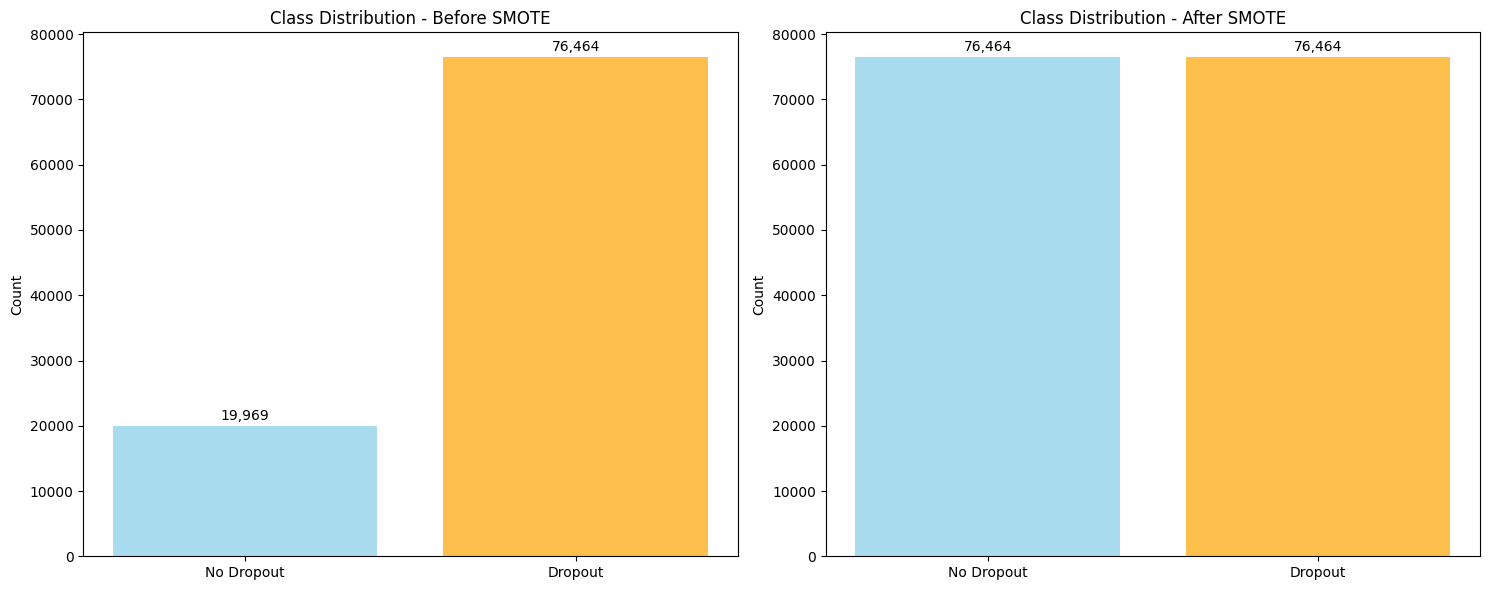


MODEL TRAINING AND EVALUATION

Training Logistic Regression...
  Original Results:
    Accuracy: 0.8527
    Precision: 0.8640
    Recall: 0.9663
    F1 Score: 0.9123
    ROC-AUC: 0.8473
  SMOTE Results:
    Accuracy: 0.8317
    Precision: 0.9077
    Recall: 0.8770
    F1 Score: 0.8921
    ROC-AUC: 0.8465

Training Random Forest...
  Original Results:
    Accuracy: 0.8562
    Precision: 0.8865
    Recall: 0.9387
    F1 Score: 0.9119
    ROC-AUC: 0.8377
  SMOTE Results:
    Accuracy: 0.8445
    Precision: 0.8970
    Recall: 0.9081
    F1 Score: 0.9025
    ROC-AUC: 0.8194

Training XGBoost...
  Original Results:
    Accuracy: 0.8594
    Precision: 0.8797
    Recall: 0.9530
    F1 Score: 0.9149
    ROC-AUC: 0.8499
  SMOTE Results:
    Accuracy: 0.8578
    Precision: 0.8815
    Recall: 0.9481
    F1 Score: 0.9136
    ROC-AUC: 0.8359

MODEL COMPARISON SUMMARY
                         Model  Accuracy  Precision  Recall     F1  ROC-AUC
Logistic Regression (Original)    0.8527     0.8640  0.96

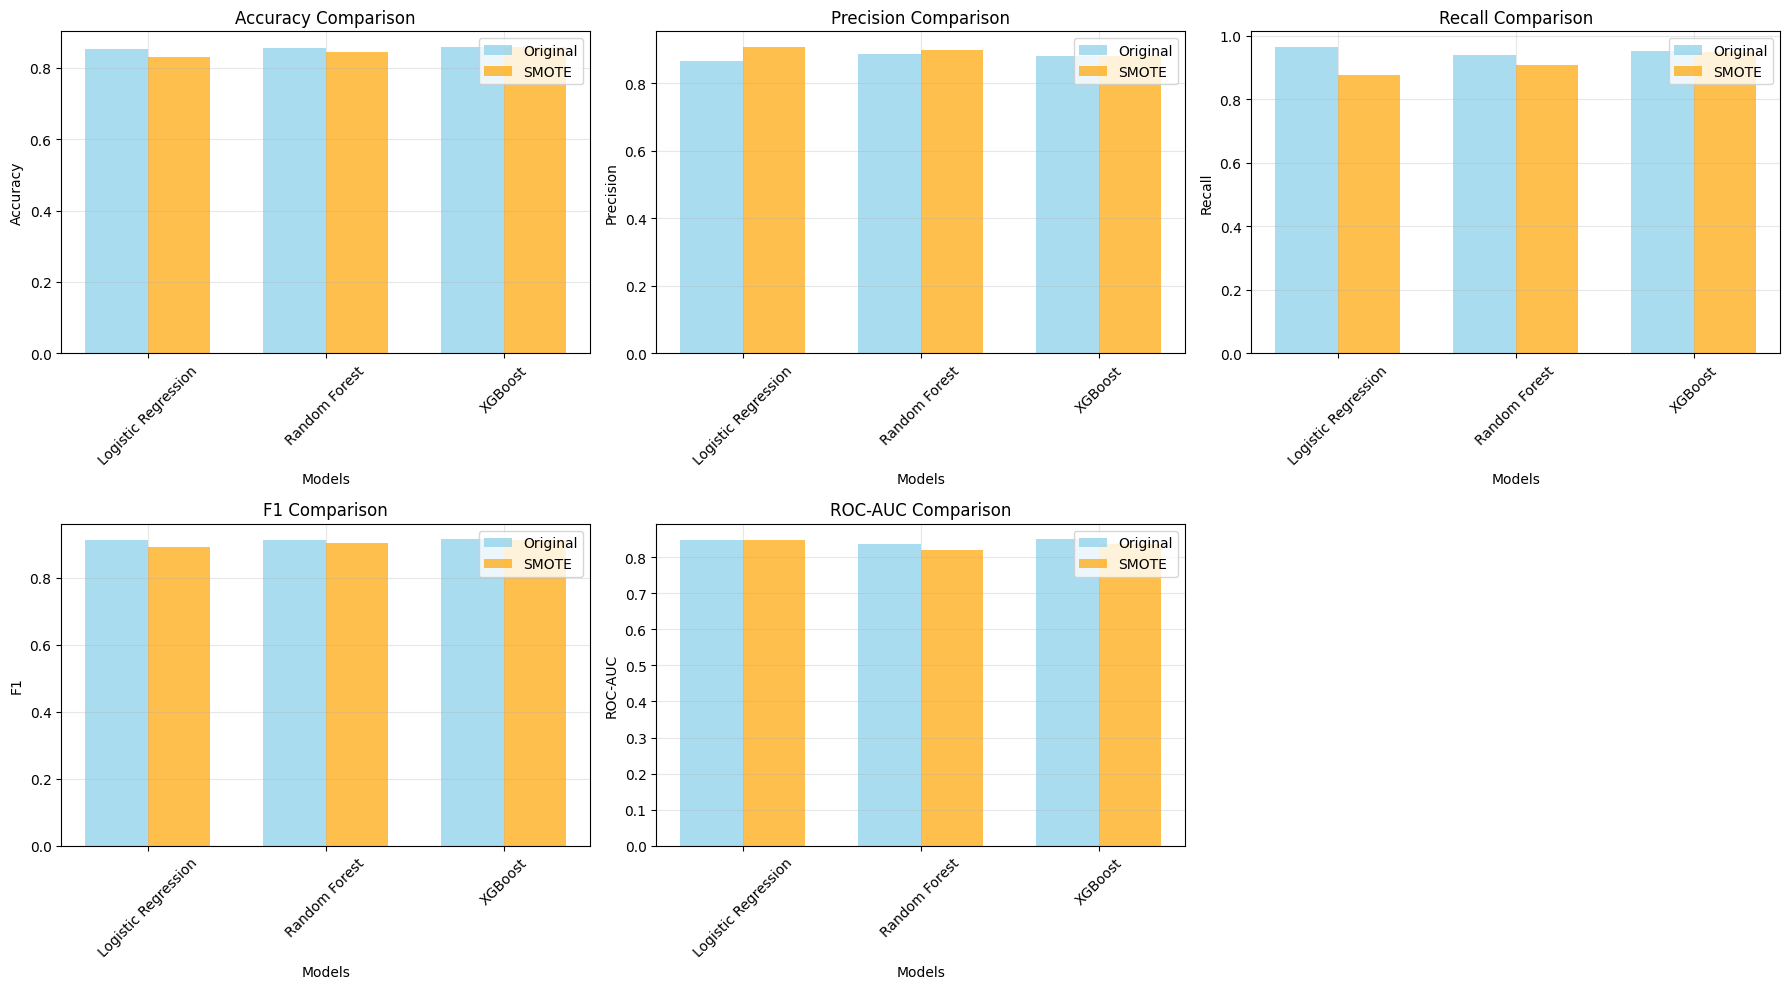


BASELINE FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features (Random Forest):
         Feature        Category  Random_Forest
    day_1_access          Access         0.0579
  day_1_navigate      Navigation         0.0432
day_1_page_close    Page Closing         0.0376
     day_1_video  Video Watching         0.0333
   day_1_problem Problem Solving         0.0317
day_1_discussion     Discussions         0.0244
    day_7_access          Access         0.0203
    day_2_access          Access         0.0199
    day_8_access          Access         0.0193
   day_21_access          Access         0.0191
   day_15_access          Access         0.0172
   day_22_access          Access         0.0171
   day_14_access          Access         0.0154
  day_2_navigate      Navigation         0.0146
  day_8_navigate      Navigation         0.0138


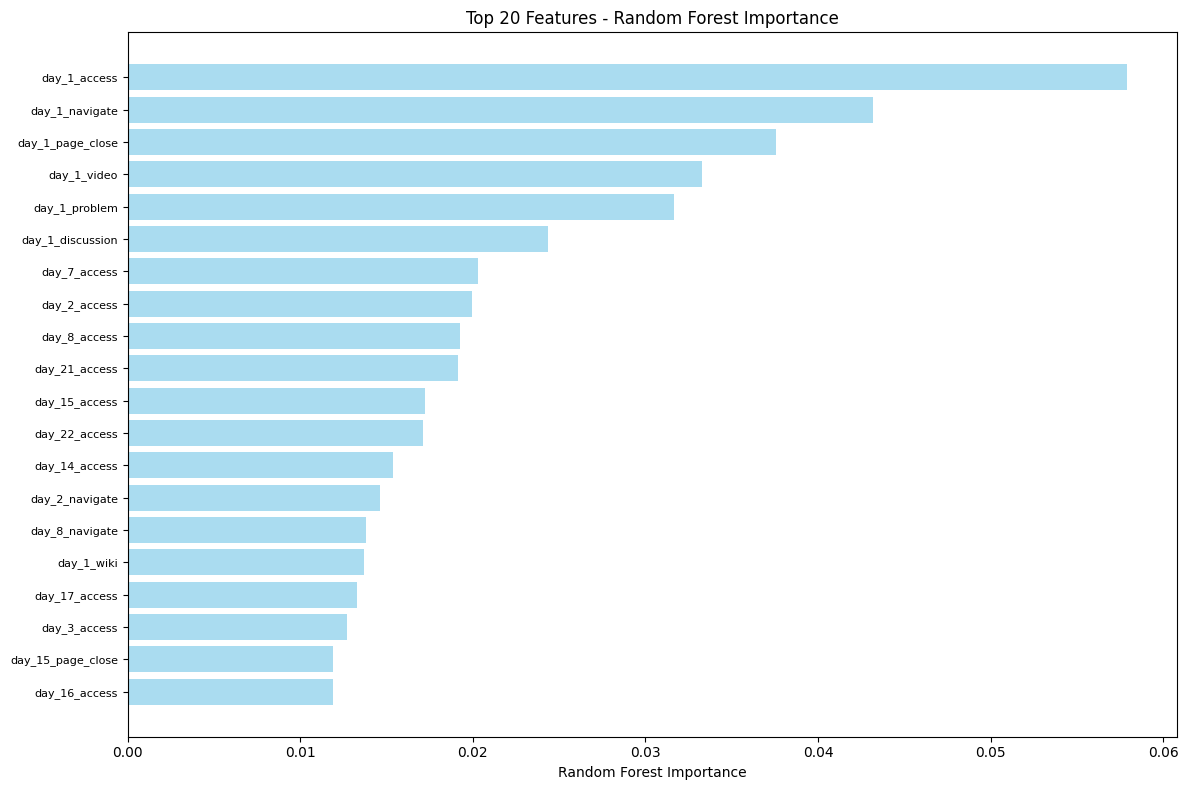


SHAP EXPLANATIONS
Using XGBoost (Original) for SHAP analysis
Computing SHAP values for 1000 samples...
SHAP values computed successfully. Shape: (1000, 210)


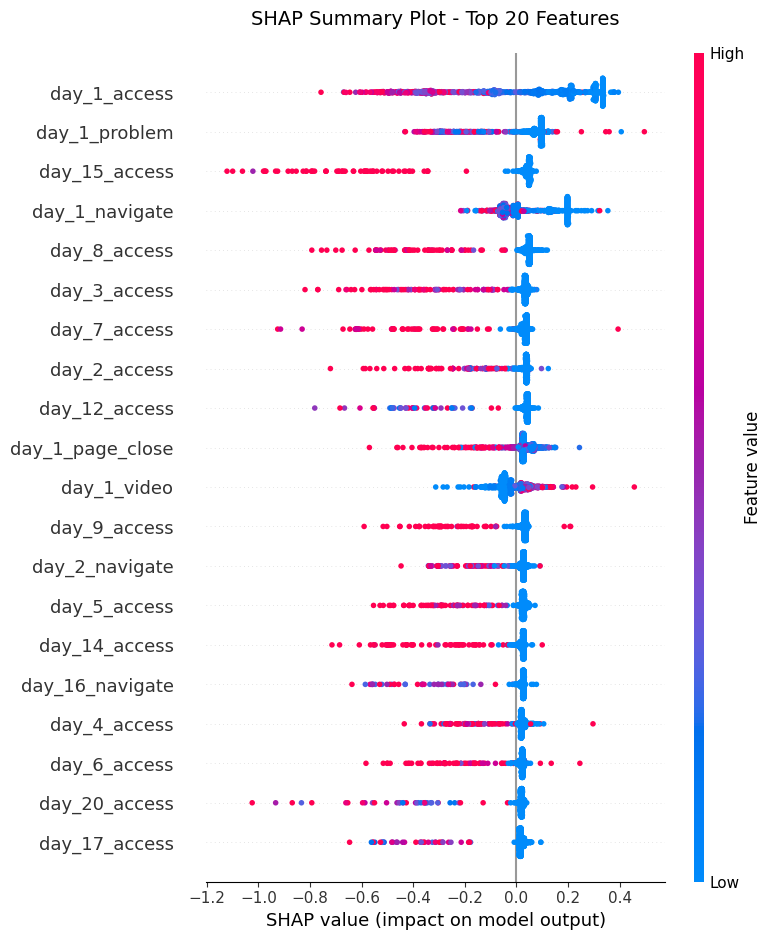

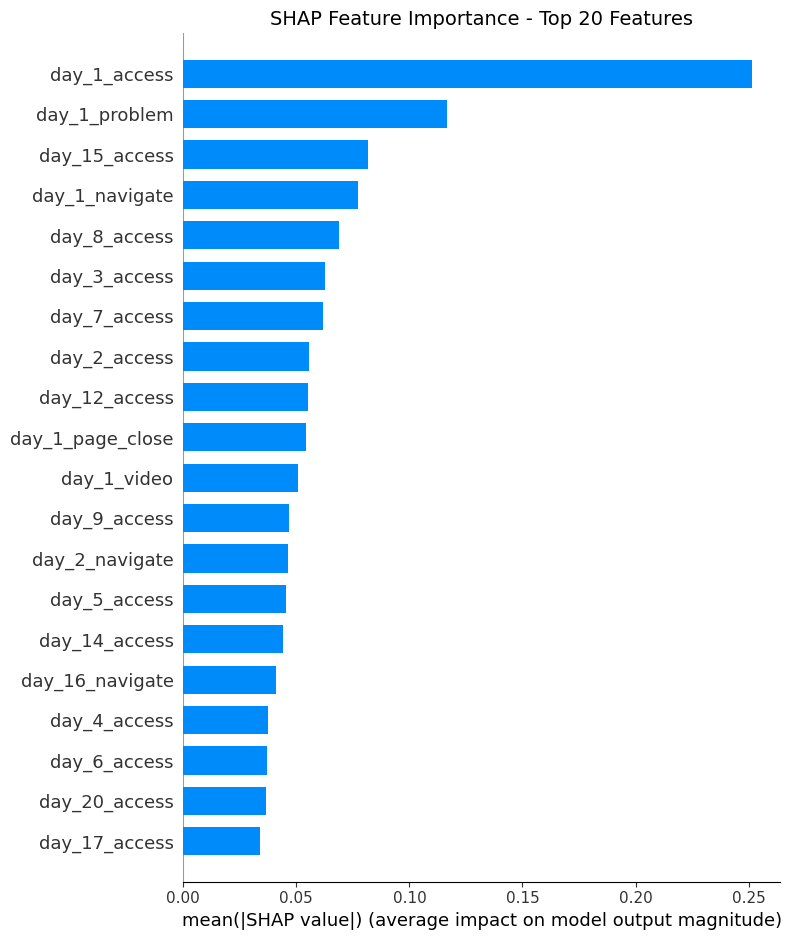

Error creating SHAP waterfall plots: waterfall() got an unexpected keyword argument 'feature_names'

LIME EXPLANATIONS
Generating LIME explanations for 6 diverse instances:

Instance 1 (Index 69058):
  Actual: Dropout
  Predicted: Dropout (Dropout prob: 0.956)

Instance 2 (Index 31653):
  Actual: Dropout
  Predicted: Dropout (Dropout prob: 0.923)

Instance 3 (Index 116861):
  Actual: Dropout
  Predicted: Dropout (Dropout prob: 0.956)

Instance 4 (Index 15845):
  Actual: No Dropout
  Predicted: No Dropout (Dropout prob: 0.093)

Instance 5 (Index 37461):
  Actual: No Dropout
  Predicted: Dropout (Dropout prob: 0.802)

Instance 6 (Index 37642):
  Actual: No Dropout
  Predicted: Dropout (Dropout prob: 0.517)


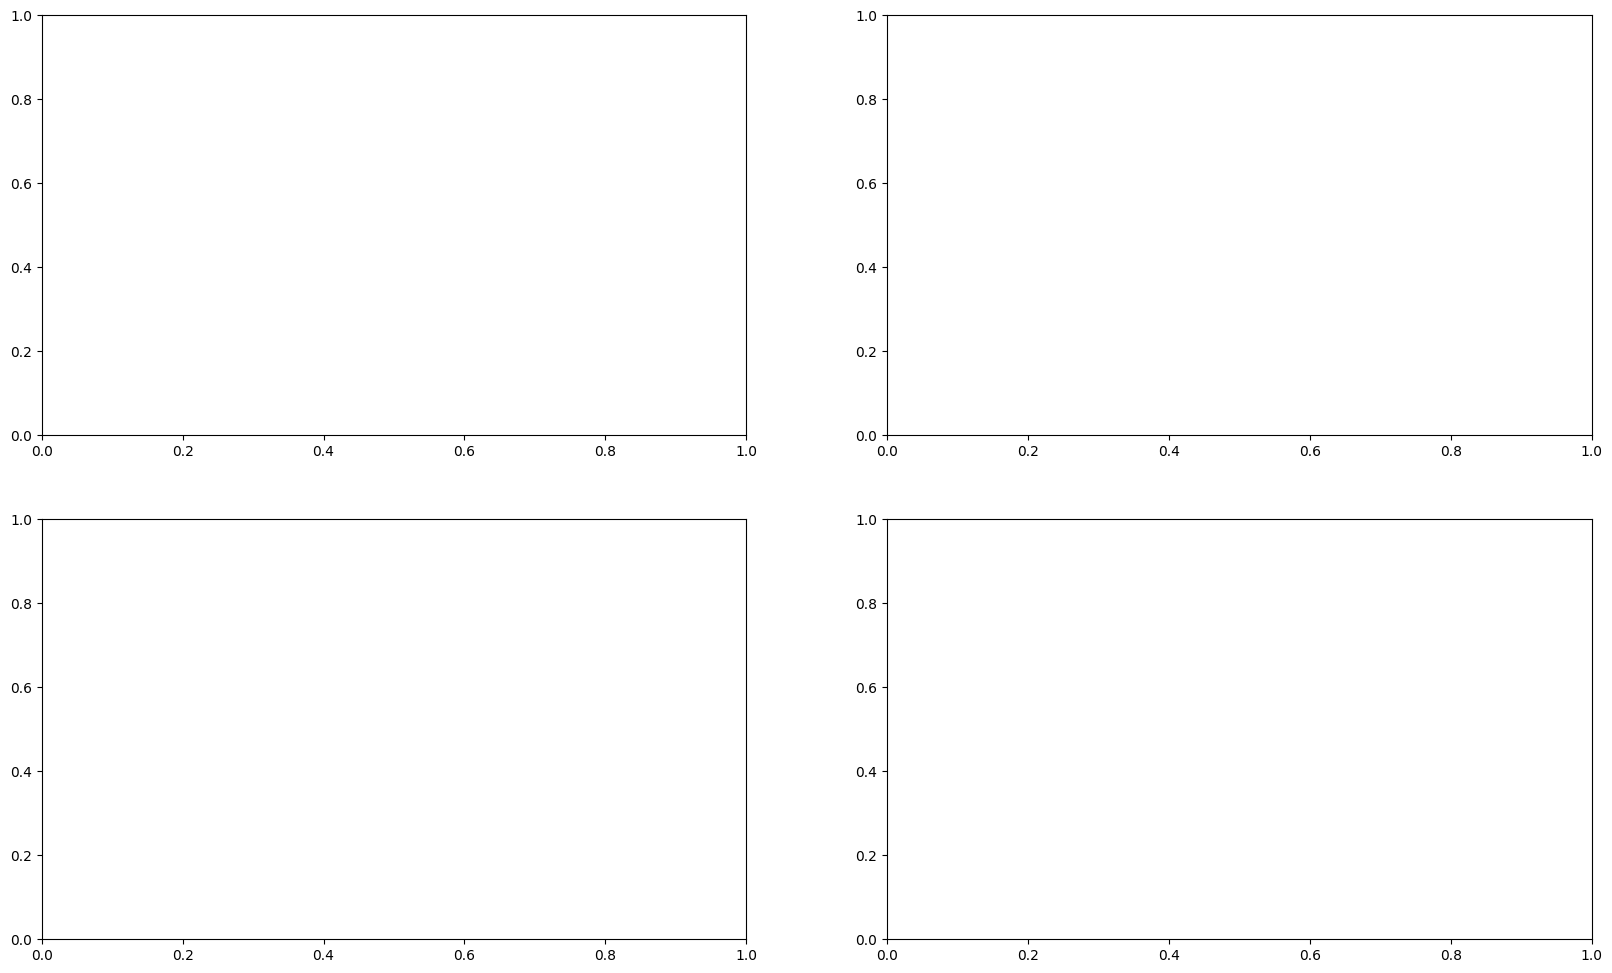

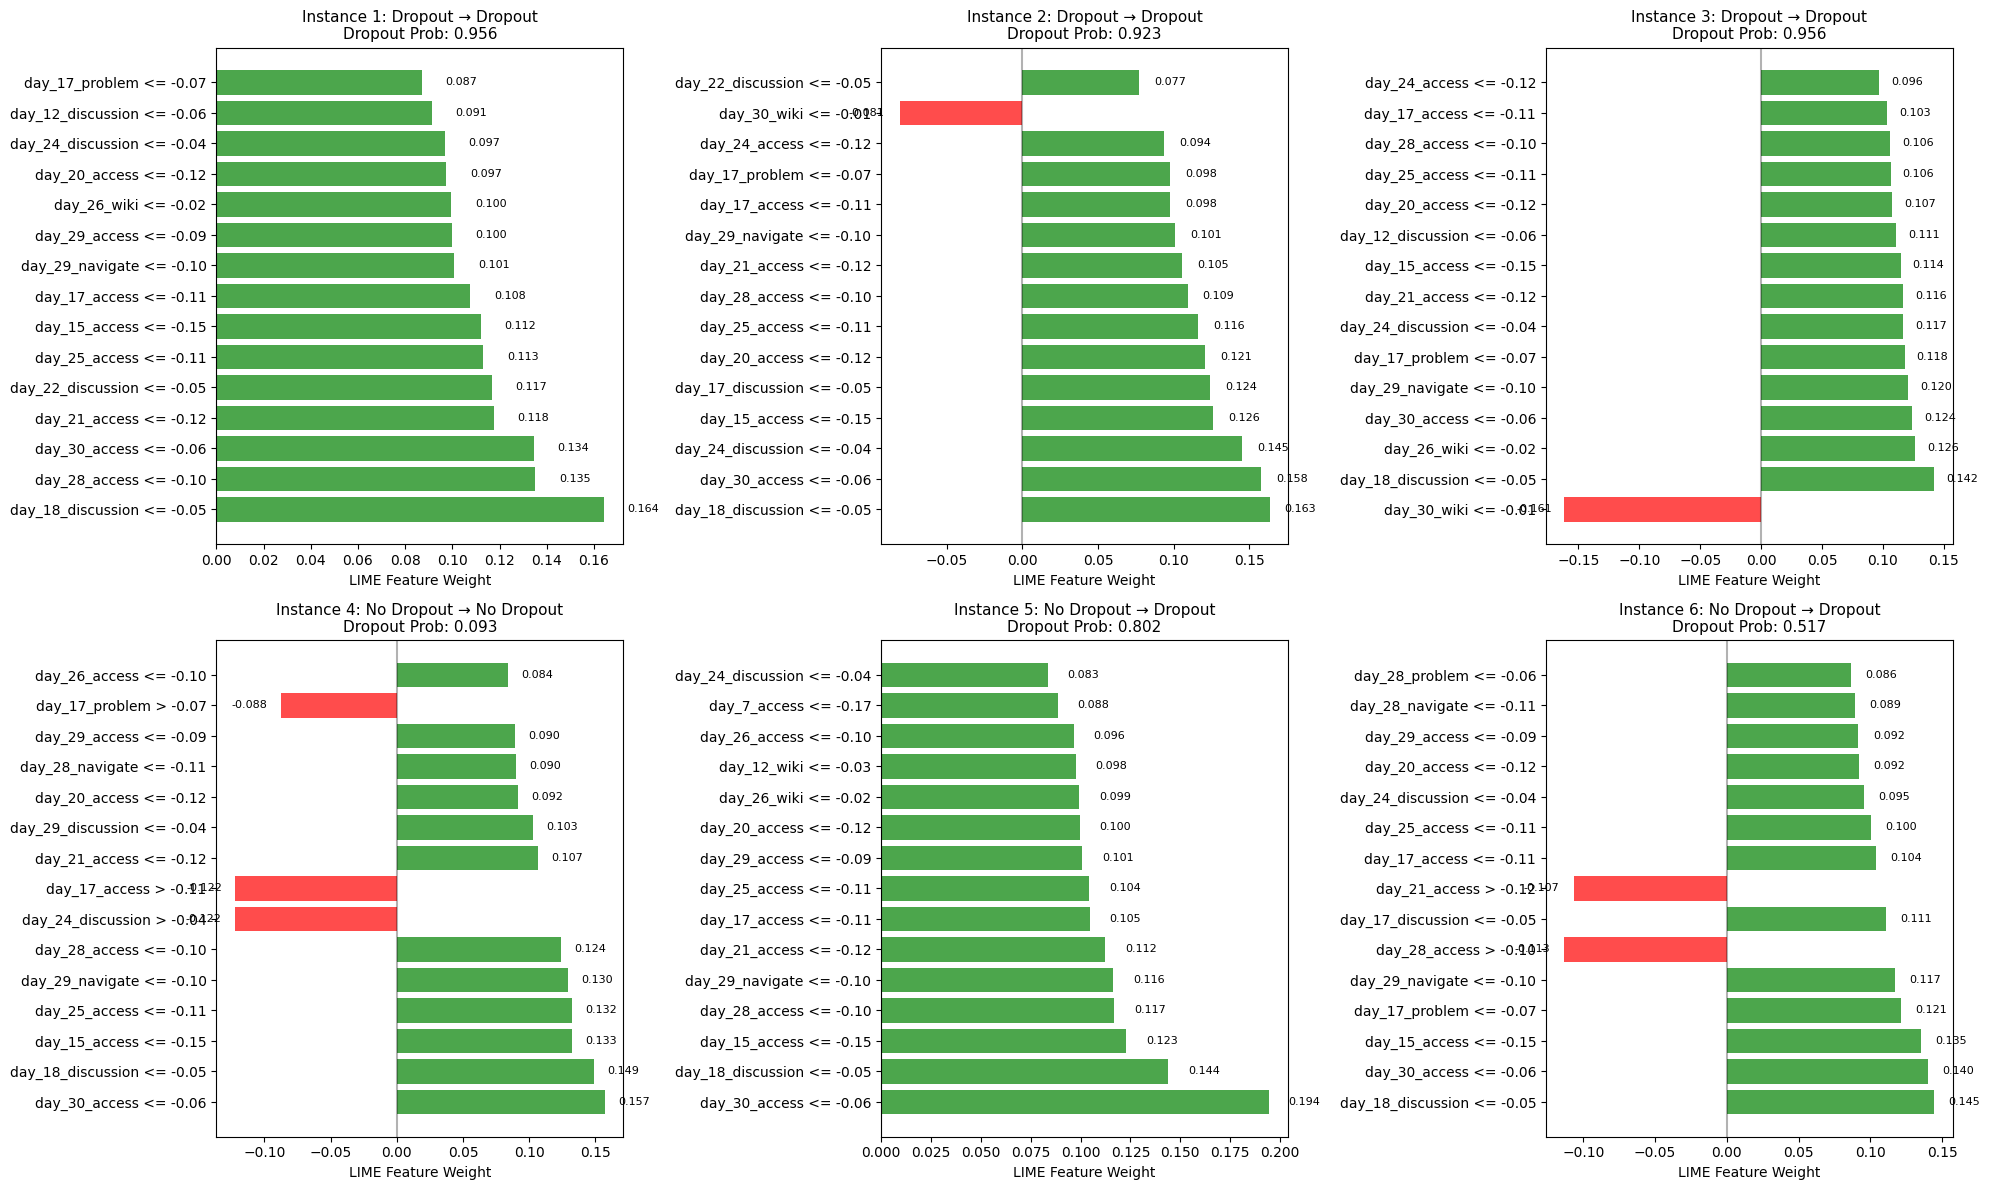


SUMMARY AND KEY INSIGHTS

1. DATASET CHARACTERISTICS:
   • Total students: 120,542
   • Features: 210
   • Dropout rate: 79.29%
   • Class imbalance ratio: 3.83:1

2. MODEL PERFORMANCE:
   • Best performing model: XGBoost (Original)
   • Best F1 Score: 0.9149
   • Best ROC-AUC: 0.8499

3. SMOTE IMPACT:
   • Average F1 without SMOTE: 0.9130
   • Average F1 with SMOTE: 0.9027
   • Improvement: -1.13%

4. TOP PREDICTIVE FEATURES:
   1. day_1_access (Category: Access)
   2. day_1_navigate (Category: Navigation)
   3. day_1_page_close (Category: Page Closing)
   4. day_1_video (Category: Video Watching)
   5. day_1_problem (Category: Problem Solving)

5. ANALYSIS COMPONENTS COMPLETED:
   • SMOTE: ✓
   • Feature Importance: ✓
   • SHAP Analysis: ✓
   • LIME Analysis: ✓

ACTIONABLE RECOMMENDATIONS

🎯 EARLY WARNING SYSTEM:
   Monitor these activities in the first 15 days:
   • Day 1: Access (Importance: 0.0579)
   • Day 1: Navigate (Importance: 0.0432)
   • Day 1: Page Close (Importance: 0.03

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import lime
import lime.lime_tabular
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=" * 80)
print("STUDENT DROPOUT PREDICTION ANALYSIS")
print("Using LIME, SHAP Explanations, and SMOTE for Class Imbalance")
print("=" * 80)

# Load the dataset
file_path = 'model1_210_features_spliting.csv'
try:
    data = pd.read_csv(file_path)
    print(f"\nDataset loaded successfully!")
    print(f"Dataset shape: {data.shape}")
except FileNotFoundError:
    print(f"Error: File {file_path} not found. Please check the file path.")
    exit()

# Drop non-numeric columns that are not useful for prediction
columns_to_drop = ['username', 'course_id', 'enrollment_id']
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
if existing_columns_to_drop:
    data = data.drop(columns=existing_columns_to_drop)
    print(f"Dropped columns: {existing_columns_to_drop}")

# Handle missing values
print(f"Missing values before cleaning: {data.isnull().sum().sum()}")
data.fillna(0, inplace=True)
print(f"Missing values after cleaning: {data.isnull().sum().sum()}")

# Separate features and target variable
if 'dropout' not in data.columns:
    print("Error: 'dropout' column not found in the dataset.")
    print(f"Available columns: {list(data.columns)}")
    exit()

X = data.drop(columns=['dropout'])  # Features
y = data['dropout']  # Target variable

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Analyze class distribution
class_distribution = Counter(y)
print(f"\nClass Distribution:")
print(f"No Dropout (0): {class_distribution[0]:,} ({class_distribution[0]/len(y)*100:.2f}%)")
print(f"Dropout (1): {class_distribution[1]:,} ({class_distribution[1]/len(y)*100:.2f}%)")
print(f"Imbalance Ratio: {class_distribution[1]/class_distribution[0]:.2f}:1")

# =============================================================================
# DATA PREPROCESSING AND SPLITTING
# =============================================================================

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train-test split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train set dropout rate: {y_train.mean():.3f}")
print(f"Test set dropout rate: {y_test.mean():.3f}")

# =============================================================================
# SMOTE APPLICATION
# =============================================================================

print(f"\n" + "="*50)
print("APPLYING SMOTE FOR CLASS IMBALANCE")
print("="*50)

# Apply SMOTE to training data
try:
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print(f"Original training set distribution:")
    print(f"  No Dropout: {Counter(y_train)[0]:,}")
    print(f"  Dropout: {Counter(y_train)[1]:,}")
    print(f"After SMOTE distribution:")
    print(f"  No Dropout: {Counter(y_train_smote)[0]:,}")
    print(f"  Dropout: {Counter(y_train_smote)[1]:,}")

    smote_success = True
except Exception as e:
    print(f"SMOTE failed: {e}")
    print("Proceeding with original imbalanced data...")
    X_train_smote, y_train_smote = X_train, y_train
    smote_success = False

if smote_success:
    # Visualize class distribution before and after SMOTE
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Before SMOTE
    y_train_counts = Counter(y_train)
    ax1.bar(['No Dropout', 'Dropout'], [y_train_counts[0], y_train_counts[1]],
            color=['skyblue', 'orange'], alpha=0.7)
    ax1.set_title('Class Distribution - Before SMOTE')
    ax1.set_ylabel('Count')
    for i, v in enumerate([y_train_counts[0], y_train_counts[1]]):
        ax1.text(i, v + 500, f'{v:,}', ha='center', va='bottom')

    # After SMOTE
    y_train_smote_counts = Counter(y_train_smote)
    ax2.bar(['No Dropout', 'Dropout'], [y_train_smote_counts[0], y_train_smote_counts[1]],
            color=['skyblue', 'orange'], alpha=0.7)
    ax2.set_title('Class Distribution - After SMOTE')
    ax2.set_ylabel('Count')
    for i, v in enumerate([y_train_smote_counts[0], y_train_smote_counts[1]]):
        ax2.text(i, v + 500, f'{v:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# =============================================================================
# MODEL TRAINING AND EVALUATION
# =============================================================================

print(f"\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Train models with and without SMOTE
models_config = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
]

# Store results
results = []
trained_models = {}

for name, model in models_config:
    print(f"\nTraining {name}...")

    try:
        # Without SMOTE
        model_original = type(model)(**model.get_params())
        model_original.fit(X_train, y_train)
        y_pred_original = model_original.predict(X_test)
        y_pred_proba_original = model_original.predict_proba(X_test)[:, 1]

        # With SMOTE (if successful)
        if smote_success:
            model_smote = type(model)(**model.get_params())
            model_smote.fit(X_train_smote, y_train_smote)
            y_pred_smote = model_smote.predict(X_test)
            y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]
        else:
            model_smote = model_original
            y_pred_smote = y_pred_original
            y_pred_proba_smote = y_pred_proba_original

        # Store trained models for later explanation
        trained_models[name] = {
            'original': model_original,
            'smote': model_smote
        }

        # Calculate metrics
        predictions = [('Original', y_pred_original, y_pred_proba_original)]
        if smote_success:
            predictions.append(('SMOTE', y_pred_smote, y_pred_proba_smote))

        for suffix, y_pred, y_pred_proba in predictions:
            metrics = {
                'Model': f"{name} ({suffix})",
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'Recall': recall_score(y_test, y_pred, zero_division=0),
                'F1': f1_score(y_test, y_pred, zero_division=0),
                'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
            }
            results.append(metrics)

            print(f"  {suffix} Results:")
            print(f"    Accuracy: {metrics['Accuracy']:.4f}")
            print(f"    Precision: {metrics['Precision']:.4f}")
            print(f"    Recall: {metrics['Recall']:.4f}")
            print(f"    F1 Score: {metrics['F1']:.4f}")
            print(f"    ROC-AUC: {metrics['ROC-AUC']:.4f}")

    except Exception as e:
        print(f"Error training {name}: {e}")
        continue

# Create results comparison DataFrame
if results:
    results_df = pd.DataFrame(results)
    print(f"\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    print(results_df.round(4).to_string(index=False))

    # Find best model
    best_model_idx = results_df['F1'].idxmax()
    best_model_results = results_df.loc[best_model_idx]
    best_model_name = best_model_results['Model'].split(' (')[0]
    best_model_type = 'smote' if 'SMOTE' in best_model_results['Model'] else 'original'
    best_model = trained_models[best_model_name][best_model_type]

    print(f"\nBest performing model: {best_model_results['Model']}")
else:
    print("No models trained successfully!")
    exit()

# Visualize model comparison
if len(results) > 1:
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]

        # Separate original and SMOTE results
        original_data = results_df[results_df['Model'].str.contains('Original')]
        smote_data = results_df[results_df['Model'].str.contains('SMOTE')]

        x = range(len(models_config))
        width = 0.35

        if len(original_data) > 0:
            ax.bar([i - width/2 for i in x], original_data[metric], width,
                   label='Original', alpha=0.7, color='skyblue')
        if len(smote_data) > 0 and smote_success:
            ax.bar([i + width/2 for i in x], smote_data[metric], width,
                   label='SMOTE', alpha=0.7, color='orange')

        ax.set_xlabel('Models')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels([name for name, _ in models_config], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Remove empty subplot
    axes[-1].remove()
    plt.tight_layout()
    plt.show()

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS (BASELINE)
# =============================================================================

print(f"\n" + "="*60)
print("BASELINE FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from Random Forest (always available)
try:
    if 'Random Forest' in trained_models:
        rf_model = trained_models['Random Forest'][best_model_type]
        rf_importance = rf_model.feature_importances_

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Random_Forest': rf_importance,
            'SHAP_Importance': np.zeros(len(X.columns))  # Initialize with zeros
        })

        # Add feature categories
        def categorize_feature(feature_name):
            if 'access' in feature_name:
                return 'Access'
            elif 'problem' in feature_name:
                return 'Problem Solving'
            elif 'video' in feature_name:
                return 'Video Watching'
            elif 'discussion' in feature_name:
                return 'Discussions'
            elif 'wiki' in feature_name:
                return 'Wiki'
            elif 'navigate' in feature_name:
                return 'Navigation'
            elif 'page_close' in feature_name:
                return 'Page Closing'
            else:
                return 'Other'

        importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)
        importance_df = importance_df.sort_values('Random_Forest', ascending=False)

        print("Top 15 Most Important Features (Random Forest):")
        print(importance_df.head(15)[['Feature', 'Category', 'Random_Forest']].round(4).to_string(index=False))

        # Visualize top features
        plt.figure(figsize=(12, 8))
        top_20 = importance_df.head(20)
        plt.barh(range(len(top_20)), top_20['Random_Forest'], color='skyblue', alpha=0.7)
        plt.yticks(range(len(top_20)), top_20['Feature'], fontsize=8)
        plt.xlabel('Random Forest Importance')
        plt.title('Top 20 Features - Random Forest Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        importance_available = True

    else:
        print("Random Forest model not available for feature importance analysis")
        importance_available = False

except Exception as e:
    print(f"Error in baseline feature importance: {e}")
    importance_available = False

# =============================================================================
# SHAP EXPLANATIONS
# =============================================================================

print(f"\n" + "="*60)
print("SHAP EXPLANATIONS")
print("="*60)

shap_success = False
try:
    if best_model_name in ['Random Forest', 'XGBoost']:
        print(f"Using {best_model_results['Model']} for SHAP analysis")

        # SHAP TreeExplainer
        explainer_shap = shap.TreeExplainer(best_model)

        # Use a subset for SHAP if dataset is large
        n_shap_samples = min(1000, len(X_test))
        X_test_shap = X_test.iloc[:n_shap_samples]

        print(f"Computing SHAP values for {n_shap_samples} samples...")
        shap_values = explainer_shap.shap_values(X_test_shap)

        # Handle different SHAP output formats
        if isinstance(shap_values, list):
            shap_values_class1 = shap_values[1]  # Dropout class
        else:
            shap_values_class1 = shap_values

        print(f"SHAP values computed successfully. Shape: {shap_values_class1.shape}")

        # Update importance_df with SHAP values if available
        if importance_available:
            shap_importance = np.abs(shap_values_class1).mean(0)
            importance_df['SHAP_Importance'] = shap_importance
            importance_df = importance_df.sort_values('Random_Forest', ascending=False)

        # 1. SHAP Summary Plot
        try:
            plt.figure(figsize=(14, 10))
            shap.summary_plot(shap_values_class1, X_test_shap, feature_names=X.columns,
                             show=False, max_display=20)
            plt.title("SHAP Summary Plot - Top 20 Features", fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating SHAP summary plot: {e}")

        # 2. SHAP Bar Plot
        try:
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values_class1, X_test_shap, feature_names=X.columns,
                              plot_type="bar", show=False, max_display=20)
            plt.title("SHAP Feature Importance - Top 20 Features", fontsize=14)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating SHAP bar plot: {e}")

        # 3. SHAP Waterfall Plots
        try:
            fig, axes = plt.subplots(2, 2, figsize=(20, 12))
            axes = axes.flatten()

            for i in range(min(4, len(X_test_shap))):
                plt.sca(axes[i])
                actual = "Dropout" if y_test.iloc[i] == 1 else "No Dropout"
                pred_proba = best_model.predict_proba([X_test_shap.iloc[i]])[0][1]
                predicted = "Dropout" if pred_proba > 0.5 else "No Dropout"

                if isinstance(shap_values, list):
                    expected_value = explainer_shap.expected_value[1]
                else:
                    expected_value = explainer_shap.expected_value

                shap.plots.waterfall(expected_value, shap_values_class1[i],
                                     X_test_shap.iloc[i], feature_names=X.columns,
                                     show=False, max_display=15)
                plt.title(f'Instance {i+1}: Actual={actual}, Pred={predicted} (p={pred_proba:.3f})',
                          fontsize=12)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating SHAP waterfall plots: {e}")

        shap_success = True

    else:
        print(f"SHAP TreeExplainer not compatible with {best_model_name}")
        print("Skipping SHAP analysis...")

except Exception as e:
    print(f"Error in SHAP analysis: {e}")
    print("Continuing without SHAP...")

# =============================================================================
# LIME EXPLANATIONS
# =============================================================================

print(f"\n" + "="*60)
print("LIME EXPLANATIONS")
print("="*60)

lime_success = False
try:
    # LIME Tabular Explainer
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_smote.values,
        training_labels=y_train_smote.values,
        mode="classification",
        feature_names=X.columns.tolist(),
        class_names=["No Dropout", "Dropout"],
        verbose=False,
        random_state=42
    )

    # Explain different types of predictions
    n_explanations = min(6, len(X_test))

    # Select diverse instances for explanation
    dropout_indices = y_test[y_test == 1].index[:n_explanations//2]
    no_dropout_indices = y_test[y_test == 0].index[:n_explanations//2]
    selected_indices = list(dropout_indices) + list(no_dropout_indices)
    selected_indices = selected_indices[:n_explanations]

    print(f"Generating LIME explanations for {len(selected_indices)} diverse instances:")

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    explanation_instances = []

    for idx, test_idx in enumerate(selected_indices):
        if idx >= len(axes):
            break

        instance = X_test.loc[test_idx].values
        actual_class = "Dropout" if y_test.loc[test_idx] == 1 else "No Dropout"

        # Get prediction probabilities
        pred_proba = best_model.predict_proba([instance])[0]
        predicted_class = "Dropout" if pred_proba[1] > 0.5 else "No Dropout"

        print(f"\nInstance {idx+1} (Index {test_idx}):")
        print(f"  Actual: {actual_class}")
        print(f"  Predicted: {predicted_class} (Dropout prob: {pred_proba[1]:.3f})")

        # Generate LIME explanation
        explanation_lime = explainer_lime.explain_instance(
            instance,
            best_model.predict_proba,
            num_features=15,
            top_labels=2
        )

        # Extract explanation data
        lime_data = explanation_lime.as_list()

        # Create visualization
        ax = axes[idx]
        features = [item[0] for item in lime_data]
        values = [item[1] for item in lime_data]
        colors = ['green' if v > 0 else 'red' for v in values]

        bars = ax.barh(features, values, color=colors, alpha=0.7)
        ax.set_xlabel('LIME Feature Weight', fontsize=10)
        ax.set_title(f'Instance {idx+1}: {actual_class} → {predicted_class}\n'
                    f'Dropout Prob: {pred_proba[1]:.3f}', fontsize=11)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            width = bar.get_width()
            ax.text(width + (0.01 if width >= 0 else -0.01),
                    bar.get_y() + bar.get_height()/2,
                    f'{value:.3f}', ha='left' if width >= 0 else 'right',
                    va='center', fontsize=8)

        # Store explanation for text summary
        explanation_instances.append({
            'index': test_idx,
            'actual': actual_class,
            'predicted': predicted_class,
            'probability': pred_proba[1],
            'features': lime_data[:5]
        })

    # Hide unused subplots
    for j in range(len(selected_indices), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    lime_success = True

except Exception as e:
    print(f"Error in LIME analysis: {e}")
    print("Continuing without LIME...")

# =============================================================================
# SUMMARY AND INSIGHTS
# =============================================================================

print(f"\n" + "="*80)
print("SUMMARY AND KEY INSIGHTS")
print("="*80)

print(f"\n1. DATASET CHARACTERISTICS:")
print(f"   • Total students: {len(data):,}")
print(f"   • Features: {len(X.columns)}")
print(f"   • Dropout rate: {y.mean()*100:.2f}%")
print(f"   • Class imbalance ratio: {class_distribution[1]/class_distribution[0]:.2f}:1")

print(f"\n2. MODEL PERFORMANCE:")
print(f"   • Best performing model: {best_model_results['Model']}")
print(f"   • Best F1 Score: {best_model_results['F1']:.4f}")
print(f"   • Best ROC-AUC: {best_model_results['ROC-AUC']:.4f}")

if smote_success and len(results_df) > 3:
    print(f"\n3. SMOTE IMPACT:")
    original_f1 = results_df[results_df['Model'].str.contains('Original')]['F1'].mean()
    smote_f1 = results_df[results_df['Model'].str.contains('SMOTE')]['F1'].mean()
    print(f"   • Average F1 without SMOTE: {original_f1:.4f}")
    print(f"   • Average F1 with SMOTE: {smote_f1:.4f}")
    print(f"   • Improvement: {((smote_f1/original_f1-1)*100):+.2f}%")

if importance_available:
    print(f"\n4. TOP PREDICTIVE FEATURES:")
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"   {i}. {row['Feature']} (Category: {row['Category']})")

print(f"\n5. ANALYSIS COMPONENTS COMPLETED:")
print(f"   • SMOTE: {'✓' if smote_success else '✗'}")
print(f"   • Feature Importance: {'✓' if importance_available else '✗'}")
print(f"   • SHAP Analysis: {'✓' if shap_success else '✗'}")
print(f"   • LIME Analysis: {'✓' if lime_success else '✗'}")

# =============================================================================
# ACTIONABLE RECOMMENDATIONS
# =============================================================================

print(f"\n" + "="*60)
print("ACTIONABLE RECOMMENDATIONS")
print("="*60)

if importance_available:
    # Identify critical early warning features
    critical_features = importance_df.head(10)
    early_critical = critical_features[critical_features['Feature'].str.contains('day_[1-9]_|day_1[0-5]_')]

    print(f"\n🎯 EARLY WARNING SYSTEM:")
    if len(early_critical) > 0:
        print(f"   Monitor these activities in the first 15 days:")
        for _, row in early_critical.iterrows():
            day = row['Feature'].split('_')[1]
            activity = '_'.join(row['Feature'].split('_')[2:])
            print(f"   • Day {day}: {activity.replace('_', ' ').title()} (Importance: {row['Random_Forest']:.4f})")
    else:
        print(f"   • Focus on top features: {', '.join(critical_features['Feature'].head(3).tolist())}")

print(f"\n📊 INTERVENTION STRATEGIES:")
print(f"   • Deploy the {best_model_results['Model']} for real-time predictions")
print(f"   • Set up automated alerts for students with dropout probability > 0.7")
print(f"   • Monitor key engagement patterns identified by the model")
print(f"   • Implement early intervention protocols for at-risk students")

print(f"\n📈 EXPECTED OUTCOMES:")
print(f"   • Model achieves {best_model_results['ROC-AUC']:.1%} ROC-AUC score")
print(f"   • Can identify {best_model_results['Recall']:.1%} of actual dropouts")
print(f"   • Precision of {best_model_results['Precision']:.1%} minimizes false alarms")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("Ready for educational implementation! 🎓")
print("="*80)